COMP 215 - LAB 4 (Graphs)
-------------------------
#### Name: Nika Ghassemi
#### Date: Mon Jan 26 2026

This lab exercise is an introduction to Graphs and Graph Analysis using [NetworkX](https://networkx.org/documentation/stable/).

**New Python concepts**:
  * **NetworkX** is an open-source package.  It provides a `Graph` object to represent a graph.
  * Built-in `random` module provides algorithms for generating pseudo-random sequences
  * [Generator expression](https://towardsdatascience.com/understanding-generator-expressions-in-python-fe0c4534619) - similar to a list comprehension, but faster and using much less memory!

**Credits**:
    Code examples based on [Think Complexity, 2nd edition](https://thinkcomplex.com).
    Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

As usual, the first code cell simply imports all the modules we'll be using...

In [4]:
%matplotlib inline

import math
import random
from timeit import timeit

import matplotlib.pyplot as plt
import networkx as nx

## ER Graph algorithms.

from the textbook...
> One of the more interesting [random graphs](https://en.wikipedia.org/wiki/Random_graph) is the Erdős-Rényi model, studied by Paul Erdős and Alfréd Rényi in the 1960s.

> An Erdős-Rényi graph (ER graph) is characterized by two parameters: $n$ is the number of nodes and $p$ is the probability that there is an edge between any two nodes.

> Erdős and Rényi studied the properties of these random graphs; one of their surprising results is the existence of abrupt changes in the properties of random graphs as random edges are added.

In this lab we will work towards re-producing this famous computational experiment.


We `seed` Python's built-in random number generator so we get the same sequence each time (to facilitate debugging and comprehension!)  Comment this out and re-run the notebook when you are ready to run experiments.

In [5]:
random.seed(6) # Comment this out to run randomized experiments

In [6]:
def all_pairs(objects):
    """ Return a generator with the complete set of distinct object pairs, as 2-tuples, from the given iterable of objects """
    return ((a, b) for i in range(1, len(objects)) for a,b in zip(objects, objects[i:]))

# unit tests
assert set( all_pairs(('w', 'x', 'y', 'z')) ) == {('w', 'x'), ('x', 'y'), ('y', 'z'), ('w', 'y'), ('x', 'z'), ('w', 'z')}

In [7]:
def coin_toss(p=0.5):
    """ Simulate flipping a biased "coin", where the probability of 'heads' is p.  Return True if 'heads', False otherwise """
    return random.random() < p

In [8]:
def random_pairs(objects, p=0.5):
    """ Return a generator of random subset of distinct object pairs (2-tuples), each with a probability of `p` """
    return (pair for pair in all_pairs(objects) if coin_toss(p))  # "flip a coin" to determine whether a given pair is included.

# Notice: no way to automate tests for random functions because they produce "side-effects" !!!
list( random_pairs(('w', 'x', 'y', 'z'), p=0.5) )

[('y', 'z'), ('w', 'y'), ('x', 'z')]

In [9]:
def make_random_graph(n, p):
    """ Return an ER Graph with n nodes, where the probability of an edge between a pair of nodes in p """
    graph = nx.Graph()
    labels = range(n)
    graph.add_nodes_from(labels)
    graph.add_edges_from(random_pairs(labels, p))
    return graph

### Experiment:  Randomly connected graphs
The following experiment creates a graph with $N$ nodes where the probability of any 2 nodes being connected is $p$

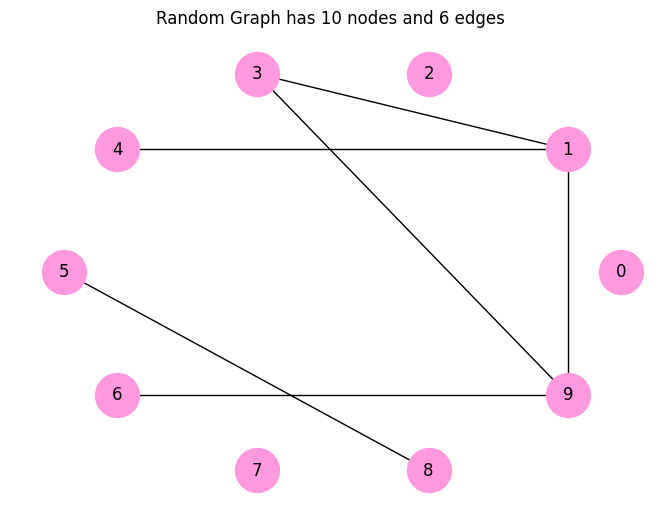

In [10]:
N = 10
p = 0.2

random_graph = make_random_graph(N, p)

nx.draw_circular(random_graph,
                 node_color='#ff99dd',
                 node_size=1000,
                 with_labels=True)
plt.gca().set(
    title=f'Random Graph has {random_graph.number_of_nodes()} nodes and {random_graph.number_of_edges()} edges'
)
plt.show()

In [11]:
def reachable_nodes(graph, start):
    """ return the set of nodes that are reachable from the given start node"""
    seen = set()
    stack = [start]
    while stack:
        node = stack.pop()
        if node not in seen:
            seen.add(node)
            stack.extend(graph.neighbors(node))
    return seen

In [12]:
def is_connected(graph):
    """ Return True if the graph is connected, false otherwise. """
    start = next(iter(graph))   # grab the first node in the graph.  This statement will need some further explanation.
    reachable = reachable_nodes(graph, start)
    return len(reachable) == len(graph)

In [13]:
is_connected(random_graph)

False

## Lab Exercises

### Exercise 1
Use `timeit` to run an experiment that times the `reachable_nodes` algorithm.
Once you understand how `timeit` works, design a small experiment to time the `reachable_nodes` algorithm for a range of graph sizes (`n`)
Plot the results of your experiment, where x = graph size (`n`) and y = avg. execution time in seconds

In [14]:
# here's an example of how to use timeit:
N = 100
p = 1
g = make_random_graph(N, p)  # when p=1, this is a complete graph!
timing_trials = 5
seconds = timeit(lambda: reachable_nodes( g,  0),  number=timing_trials)
f'Avg. time to execute: {seconds/timing_trials} seconds'

'Avg. time to execute: 0.0006368593999980021 seconds'

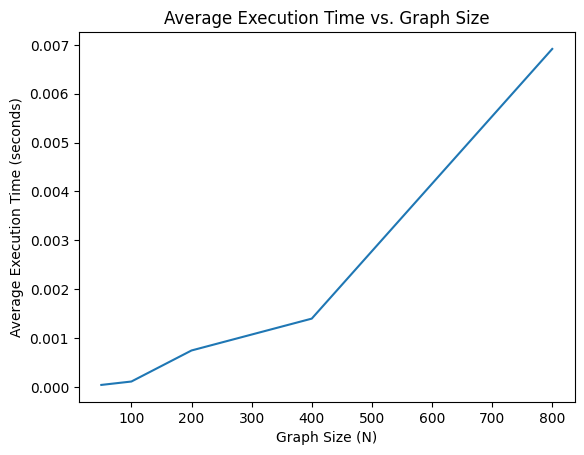

In [21]:
# Ex. 1 your code here...
graph_sizes = [50, 100, 200, 400, 800]
avg_times = []
trials = 5

for n in graph_sizes:
    p = 0.1
    g = make_random_graph(n, p)
    seconds = timeit(lambda: reachable_nodes(g, 0), number=trials)
    avg_time = seconds / trials
    avg_times.append(avg_time)

plt.plot(graph_sizes, avg_times)
plt.xlabel('Graph Size (N)')
plt.ylabel('Average Execution Time (seconds)')
plt.title('Average Execution Time vs. Graph Size')
plt.show()

### Exercise 2:
What is the **Big-O time complexity** of the `reachable_nodes` algorithm?


#### Ex. 2 Your Answer:
The Big-O time complexity of `reachable_nodes` is O(V + E), where V is the number of vertices and E is the number of edges.

## Likelihood of connectivity

We are ready to replicate Erdős and Rényi's computational experiment.
In this experiment, we estimate the likelihood that a randomly-generated ER graph is connected.

Like most computational experiments, we simple "brute force" the solution - create a big pile of ER graphs, and simply count up how many of them are connected.

### Exercise 3:
Write a function that runs one ER experiment for a given value of $n$ and $p$.

The function generates `n_trials` (number of trials) graphs and returns the proportion of them that are connected.

In [26]:
def proportion_connected(n, p, n_trials=100):
    """ Return the proportion of random ER Graphs (n, p) that are connected out of n_trials. """
    # Ex. 3 your code here...
    # Step 1: make n_trials random graphs
    connected_graphs = 0
    for _ in range(n_trials):
        graph = make_random_graph(n, p)
        if is_connected(graph):
            connected_graphs += 1

    # Step 2: compute the proportion of those graphs that are connected
    return 0

n = 30
p = 0.1
p_connected = proportion_connected(n, p)*100
f'Likelihood that an ER graph (n={n}, p={p}) is connected: {p_connected:.1f}%'

'Likelihood that an ER graph (n=30, p=0.1) is connected: 0.0%'

### Exercise 4:
Our experimental results will be more accurate (i.e., show less variation between runs) when we use large for `n_trials`.  But we've seen that large values for `n` can cause serious performance issues.
Experiment a little to find a reasonable value of `n_trials` to experiment with.  Ideally you would produce a timing graph like the one in Ex. 1, but that's optional

In [28]:
# Ex. 4 timing experiments

What is a reasonable value for `n_trials` to use in the experimental setup below where we will run trials for 20 different values of $p$?

#### Your Answer:


## Critical Value of $p$

Near a "critical value" of $p$, the likelihood of a random graph being connected rapidly changes from near 0 to near 1.
Erdős and Rényi predict the critical value should be:  $ln(n) / n$
For example...

In [ ]:
n = 30
f'Erdős and Rényi predict the critical value of p for graphs of size {n} = {math.log(n) / n:0.3f}'

'Erdős and Rényi predict the critical value of p for graphs of size 30 = 0.113'

### Exercise 5:
Develop an experimental setup that estimates the `proportion_connected` for different values for $p$.
You will need to define a suitable range of values for $p$, and choose a value for $n_trials$ (determined above).
The goal of this experiment is to plot $p$ against `proportion_connected(p)` to identify the "critical value" of $p$ for graphs of size $n$.  This will be the point where the random graphs change from being primarily disconnected to being primarily connected.

In [ ]:
# Ex. 5 your code here...


### Exercise 6:
Does your experiment confirm or refute Erdős and Rényi's results?

What real-world applications / implications might this understanding of graph connectivity have?

#### Ex. 6 Your Answer:
